# 2.3 Multivariate LSTM Model using Stoploss

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from functools import reduce
from pandas import read_csv
from matplotlib import pyplot

# Import LSTM libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from keras.preprocessing.timeseries import TimeseriesGenerator
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import tensorflow as tf 
tf.keras.preprocessing.timeseries_dataset_from_array

<function keras.src.utils.timeseries_dataset_utils.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride=1, sampling_rate=1, batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None)>

In [2]:
# Import all datasets
oil_data_clean = pd.read_csv('cleaned_oil.csv')
ppi_data_clean = pd.read_csv('cleaned_ppi.csv')
unemp_data_clean = pd.read_csv('cleaned_unemp.csv')
lcpi_data_clean = pd.read_csv('cleaned_lagged_cpi.csv')
cpi_data_clean = pd.read_csv('cleaned_cpi.csv')

In [3]:
oil_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
ppi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
unemp_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
lcpi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
cpi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)

In [4]:
cpi_data_clean.fillna(method='bfill')
lcpi_data_clean.fillna(method='bfill')
oil_data_clean.fillna(method='bfill')
ppi_data_clean.fillna(method='bfill')
unemp_data_clean.fillna(method='bfill')

C:\Users\Suryanshu Choudhary\AppData\Local\Temp\ipykernel_9472\728974245.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cpi_data_clean.fillna(method='bfill')
C:\Users\Suryanshu Choudhary\AppData\Local\Temp\ipykernel_9472\728974245.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lcpi_data_clean.fillna(method='bfill')
C:\Users\Suryanshu Choudhary\AppData\Local\Temp\ipykernel_9472\728974245.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_data_clean.fillna(method='bfill')
C:\Users\Suryanshu Choudhary\AppData\Local\Temp\ipykernel_9472\728974245.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ppi_data_clean.fi

,Date,ChangePercentMonth
0,1948-01,0.175000
1,1948-02,0.175000
2,1948-03,-0.042553
3,1948-04,-0.111111
4,1948-05,-0.150000
...,...,...
882,2021-07,-0.065574
883,2021-08,-0.070175
884,2021-09,-0.132075
885,2021-10,-0.065217


In [5]:
oil_data_clean.columns = ['Date','Oil']
oil_data_clean.dropna(inplace = True)
ppi_data_clean.columns = ['Date','PPI']
ppi_data_clean.dropna(inplace = True)
unemp_data_clean.columns = ['Date','Unemployment']
unemp_data_clean.dropna(inplace = True)
lcpi_data_clean.columns = ['Date','LaggedCPI']
lcpi_data_clean.dropna(inplace = True)
cpi_data_clean.columns = ['Date','CPI']
cpi_data_clean.dropna(inplace = True)

dataframe_list = [cpi_data_clean, oil_data_clean, ppi_data_clean, unemp_data_clean, lcpi_data_clean]
# Join all datasets together
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='inner'), dataframe_list)
df_merged.set_index('Date', inplace = True)

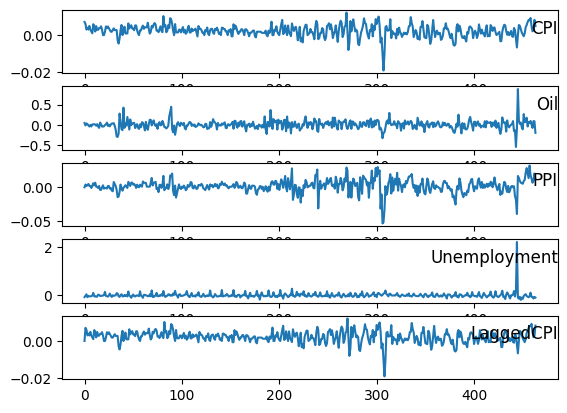

In [6]:
values = df_merged.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df_merged.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [7]:
# Data Preparation for LSTM Model
df_merged

,CPI,Oil,PPI,Unemployment,LaggedCPI
Date,,,,,
1983-04,0.007150,0.046464,0.000000,-0.074074,0.000000
1983-05,0.006085,-0.012406,0.003984,-0.020000,0.007150
1983-06,0.003024,0.037355,0.001984,0.040816,0.006085
1983-07,0.004020,0.019758,0.002970,-0.078431,0.003024
1983-08,0.003003,-0.012813,0.004936,-0.021277,0.004020
...,...,...,...,...,...
2021-07,0.004811,0.006533,0.012888,-0.065574,0.009291
2021-08,0.002066,-0.073698,0.006750,-0.070175,0.004811
2021-09,0.002716,0.095328,0.009695,-0.132075,0.002066


In [8]:
df_merged.isnull().sum()

CPI             0
Oil             0
PPI             0
Unemployment    0
LaggedCPI       0
dtype: int64

In [9]:
# Splitting the dataset into train and test sets
df_train = df_merged.iloc[:357]
df_test = df_merged.iloc[357:]

In [10]:
# Use MinMaxScaler to normalise are values by scaling down values between a range of -1 to 1
# Instantiate scaler objects
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

x_train = x_scaler.fit_transform(df_train[['Oil','PPI','Unemployment','LaggedCPI']])
y_train = y_scaler.fit_transform(df_train[['CPI']])

x_test = x_scaler.transform(df_test[['Oil','PPI','Unemployment','LaggedCPI']])
y_test = y_scaler.transform(df_test[['CPI']])

In [11]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(357, 1, 4) (357, 1) (107, 1, 4) (107, 1)


Epoch 1/500
357/357 - 6s - 17ms/step - loss: 0.0266 - val_loss: 0.0219
Epoch 2/500
357/357 - 2s - 7ms/step - loss: 0.0166 - val_loss: 0.0256
Epoch 3/500
357/357 - 2s - 5ms/step - loss: 0.0165 - val_loss: 0.0315
Epoch 4/500
357/357 - 2s - 5ms/step - loss: 0.0164 - val_loss: 0.0392
Epoch 5/500
357/357 - 2s - 4ms/step - loss: 0.0163 - val_loss: 0.0483
Epoch 6/500
357/357 - 3s - 7ms/step - loss: 0.0162 - val_loss: 0.0583
Epoch 7/500
357/357 - 2s - 4ms/step - loss: 0.0161 - val_loss: 0.0693
Epoch 8/500
357/357 - 3s - 10ms/step - loss: 0.0160 - val_loss: 0.0810
Epoch 9/500
357/357 - 2s - 6ms/step - loss: 0.0159 - val_loss: 0.0933
Epoch 10/500
357/357 - 2s - 5ms/step - loss: 0.0158 - val_loss: 0.1060
Epoch 11/500
357/357 - 3s - 9ms/step - loss: 0.0157 - val_loss: 0.1189
Epoch 12/500
357/357 - 2s - 5ms/step - loss: 0.0156 - val_loss: 0.1316
Epoch 13/500
357/357 - 3s - 9ms/step - loss: 0.0155 - val_loss: 0.1437
Epoch 14/500
357/357 - 3s - 8ms/step - loss: 0.0154 - val_loss: 0.1549
Epoch 15/500


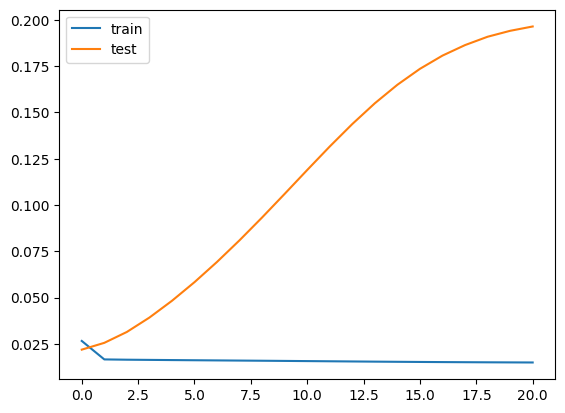

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Design network with 100 neurons
model = Sequential()
model.add(LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Define Stop-Loss callback
stop_loss = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1)

# Fit network with Stop-Loss
history = model.fit(x_train, y_train, epochs=500, batch_size=1, validation_data=(x_test, y_test), 
                    callbacks=[stop_loss], verbose=2, shuffle=False)

# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test RMSE: 0.006951540782880145
Test MAE: 0.0020899201532807985


C:\Users\Suryanshu Choudhary\AppData\Local\Temp\ipykernel_9472\3692853901.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predicted CPI'] = inv_yhat


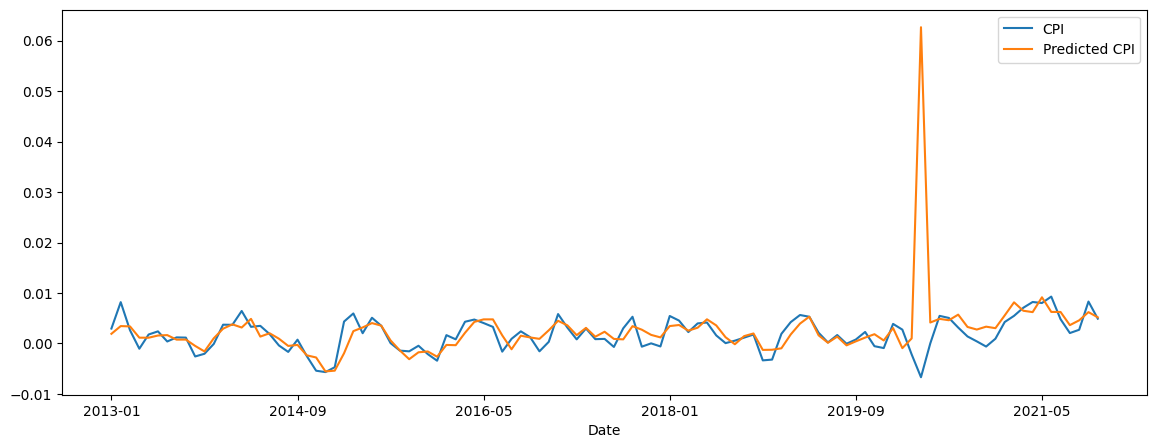

In [26]:
## Testing the Model
from sklearn.metrics import mean_absolute_error, r2_score
# make a prediction
yhat = model.predict(x_test)
# invert scaling for our forecast
inv_yhat = y_scaler.inverse_transform(yhat)
# Add our forecast to the test dataframe and plot the results
df_test['Predicted CPI'] = inv_yhat
df_test[['CPI','Predicted CPI']].plot(figsize=(14,5))
# Calculate RMSE
multi_rmse = sqrt(mean_squared_error(df_test['CPI'], df_test['Predicted CPI']))
print('Test RMSE:', multi_rmse)
# Calculate MAE
multi_mae = mean_absolute_error(df_test['CPI'], df_test['Predicted CPI'])
print('Test MAE:', multi_mae)

In [27]:
df_test

,CPI,Oil,PPI,Unemployment,LaggedCPI,Predicted CPI
Date,,,,,,
2013-01,0.002957,0.061751,0.004963,0.118421,-0.002693,0.001917
2013-02,0.008190,-0.055801,0.008889,-0.047059,0.002957,0.003447
2013-03,0.002615,0.056274,-0.001468,-0.061728,0.008190,0.003381
2013-04,-0.001040,-0.038774,-0.002451,-0.065789,0.002615,0.001150
2013-05,0.001780,-0.015943,0.002948,0.028169,-0.001040,0.001141
...,...,...,...,...,...,...
2021-07,0.004811,0.006533,0.012888,-0.065574,0.009291,0.006242
2021-08,0.002066,-0.073698,0.006750,-0.070175,0.004811,0.003635
2021-09,0.002716,0.095328,0.009695,-0.132075,0.002066,0.004586


In [28]:
print('Multivariate Long Short Memory Network RMSE:' , multi_rmse)
print('Multivariate Long Short Memory Network MAE:' , multi_mae)

Multivariate Long Short Memory Network RMSE: 0.006951540782880145
Multivariate Long Short Memory Network MAE: 0.0020899201532807985
